In [1]:
import pandas as pd

df = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv', index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Analysieren Sie die Review-Texte hinsichtlich ihrer Länge und häufigsten Wörter.

- Wie viele Wörter enthält durchschnittlich ein Review?
- Was sind die 10 häufigsten Wörter in allen Reviews?
- Wie viele einzigartige Wörter gibt es insgesamt?

In [4]:
import nltk
from collections import Counter
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords from nltk
nltk.download('stopwords')
nltk.download('punkt')
# Initialize spacy model
nlp = spacy.load('en_core_web_sm')

# Handle missing values by filling them with an empty string
df["Review Text"] = df["Review Text"].fillna("")

df_lower = df["Review Text"].str.lower()

average_words_per_review = df_lower.str.split().str.len().mean()
print(f"Average number of words per review: {average_words_per_review}")

# Remove stopwords and tokenize using nltk
stop_words = set(stopwords.words('english'))
df_lower_no_stopwords = df_lower.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.isalnum() and word not in stop_words]))

# Find the 10 most common words using nltk
all_words = ' '.join(df_lower_no_stopwords).split()
word_freq_nltk = Counter(all_words)
common_words_nltk = word_freq_nltk.most_common(10)
print(f"10 most common words using nltk: {common_words_nltk}")

# Tokenize and remove stopwords using spacy
df_lower_no_stopwords_spacy = df_lower.apply(lambda x: ' '.join([token.text for token in nlp(x) if not token.is_stop and token.is_alpha]))

# Find the 10 most common words using spacy
all_words_spacy = ' '.join(df_lower_no_stopwords_spacy).split()
word_freq_spacy = Counter(all_words_spacy)
common_words_spacy = word_freq_spacy.most_common(10)
print(f"10 most common words using spacy: {common_words_spacy}")

# Count unique words using nltk
unique_words_nltk = len(set(all_words))
print(f"Total unique words using nltk: {unique_words_nltk}")

# Count unique words using spacy
unique_words_spacy = len(set(all_words_spacy))
print(f"Total unique words using spacy: {unique_words_spacy}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benedikt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/benedikt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average number of words per review: 58.030869454142895
10 most common words using nltk: [('dress', 10497), ('love', 8940), ('size', 8700), ('top', 7348), ('fit', 7275), ('like', 7010), ('wear', 6422), ('great', 6100), ('would', 5428), ('5', 5007)]
10 most common words using spacy: [('dress', 10542), ('love', 8946), ('size', 8751), ('fit', 7309), ('like', 7145), ('wear', 6436), ('great', 6103), ('fabric', 4790), ('small', 4704), ('color', 4593)]
Total unique words using nltk: 13768
Total unique words using spacy: 13231


Identifizieren Sie Produktmarken, Größenangaben und andere relevante Entities in den Reviews.

- Welche Entities werden in diesem Review erkannt?
- Welche Größenangaben kommen in den Reviews am häufigsten vor?
- Welche Produkttypen werden am häufigsten genannt?

In [5]:
# Extract entities from the reviews using spacy
df['entities'] = df_lower.apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

# Display the first few rows of the dataframe with entities
print(df[['Review Text', 'entities']].head())

# Extract sizes and product types from the entities
sizes = []
product_types = []

for entities in df['entities']:
    for entity in entities:
        if entity[1] == 'QUANTITY':
            sizes.append(entity[0])
        elif entity[1] == 'PRODUCT':
            product_types.append(entity[0])

# Find the most common sizes and product types
common_sizes = Counter(sizes).most_common(10)
common_product_types = Counter(product_types).most_common(10)

print(f"Most common sizes: {common_sizes}")
print(f"Most common product types: {common_product_types}")

                                         Review Text  \
0  Absolutely wonderful - silky and sexy and comf...   
1  Love this dress!  it's sooo pretty.  i happene...   
2  I had such high hopes for this dress and reall...   
3  I love, love, love this jumpsuit. it's fun, fl...   
4  This shirt is very flattering to all due to th...   

                               entities  
0                                    []  
1                     [(5'8, CARDINAL)]  
2  [(half, CARDINAL), (half, CARDINAL)]  
3                                    []  
4                                    []  
Most common sizes: [('a ton', 75), ('a few inches', 36), ('5 feet', 29), ('a couple inches', 16), ('about 2 inches', 14), ('2 inches', 14), ('120 pounds', 13), ('130 pounds', 13), ('a couple of inches', 12), ('145 pounds', 12)]
Most common product types: [('billowy', 3), ('0-2/xs', 1), ('macintosh', 1), ('buttons.i', 1), ("5'9", 1), ('dd34', 1), ('sz26', 1), ('yuck', 1), ('quality.verses', 1), ('dress.fabric

In [8]:
from textblob import TextBlob
from spacy.tokens import Doc

nltk.download('vader_lexicon')

# Register the polarity extension with spaCy
Doc.set_extension('polarity', getter=lambda doc: TextBlob(doc.text).sentiment.polarity)

# Function to get the polarity of a review using TextBlob
def get_polarity_textblob(text):
    return TextBlob(text).sentiment.polarity

# Function to get the polarity of a review using nltk
def get_polarity_nltk(text):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

# Function to get the polarity of a review using spacy
def get_polarity_spacy(text):
    doc = nlp(text)
    return doc._.polarity

# Apply the functions to the 'Review Text' column
df['polarity_textblob'] = df['Review Text'].apply(get_polarity_textblob)
df['polarity_nltk'] = df['Review Text'].apply(get_polarity_nltk)
df['polarity_spacy'] = df['Review Text'].apply(get_polarity_spacy)

# Display the first few rows of the dataframe with polarity
print(df[['Review Text', 'polarity_textblob', 'polarity_nltk', 'polarity_spacy']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/benedikt/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                         Review Text  polarity_textblob  \
0  Absolutely wonderful - silky and sexy and comf...           0.633333   
1  Love this dress!  it's sooo pretty.  i happene...           0.339583   
2  I had such high hopes for this dress and reall...           0.073675   
3  I love, love, love this jumpsuit. it's fun, fl...           0.550000   
4  This shirt is very flattering to all due to th...           0.512891   

   polarity_nltk  polarity_spacy  
0         0.8932        0.633333  
1         0.9729        0.339583  
2         0.9427        0.073675  
3         0.5727        0.550000  
4         0.9291        0.512891  


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
df = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv', index_col=0)
df.head()

# nltk.download('vader_lexicon')

model = SentimentIntensityAnalyzer()


df["Review Text"] = df["Review Text"].fillna("")
df["Review Text"]

0        Absolutely wonderful - silky and sexy and comf...
1        Love this dress!  it's sooo pretty.  i happene...
2        I had such high hopes for this dress and reall...
3        I love, love, love this jumpsuit. it's fun, fl...
4        This shirt is very flattering to all due to th...
                               ...                        
23481    I was very happy to snag this dress at such a ...
23482    It reminds me of maternity clothes. soft, stre...
23483    This fit well, but the top was very see throug...
23484    I bought this dress for a wedding i have this ...
23485    This dress in a lovely platinum is feminine an...
Name: Review Text, Length: 23486, dtype: object

In [39]:
from nltk.tokenize import word_tokenize
import numpy as np

nltk.download("punkt_tab")
# zu hause
# nltk.download("all")


def get_vader_score(review):
    tokenized_words = word_tokenize(review)
    return np.sum([model.polarity_scores(tokenized_word)['compound'] for tokenized_word in tokenized_words])

df["vader_scores"] = df["Review Text"].apply(get_vader_score)
df["vader_scores"]

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/benedikt/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0        1.6092
1        3.4903
2        1.9360
3        4.1279
4        1.8002
          ...  
23481    1.6822
23482    1.0498
23483    1.9204
23484    2.2763
23485    2.0244
Name: vader_scores, Length: 23486, dtype: float64

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize


sia = SentimentIntensityAnalyzer()


def get_word_polarity(review):
    words = word_tokenize(review)
    return {word: sia.polarity_scores(word)['compound'] for word in words}


df['Review Text'] = df['Review Text'].fillna('')
df['word_polarity'] = df['Review Text'].apply(get_word_polarity)

print(df[['Review Text', 'word_polarity']].head())

                                         Review Text  \
0  Absolutely wonderful - silky and sexy and comf...   
1  Love this dress!  it's sooo pretty.  i happene...   
2  I had such high hopes for this dress and reall...   
3  I love, love, love this jumpsuit. it's fun, fl...   
4  This shirt is very flattering to all due to th...   

                                       word_polarity  
0  {'Absolutely': 0.0, 'wonderful': 0.5719, '-': ...  
1  {'Love': 0.6369, 'this': 0.0, 'dress': 0.0, '!...  
2  {'I': 0.0, 'had': 0.0, 'such': 0.0, 'high': 0....  
3  {'I': 0.0, 'love': 0.6369, ',': 0.0, 'this': 0...  
4  {'This': 0.0, 'shirt': 0.0, 'is': 0.0, 'very':...  


In [6]:
df['polarity_score'] = df['Review Text'].apply(lambda x: sia.polarity_scores(x)['compound'])

print(df[['Review Text', 'polarity_score']].head())

                                         Review Text  polarity_score
0  Absolutely wonderful - silky and sexy and comf...          0.8932
1  Love this dress!  it's sooo pretty.  i happene...          0.9729
2  I had such high hopes for this dress and reall...          0.9427
3  I love, love, love this jumpsuit. it's fun, fl...          0.5727
4  This shirt is very flattering to all due to th...          0.9291


In [24]:
df["Review Length (split ' ')"] = df["Review Text"].str.split().apply(len)
df["Review Length (word_tokens)"] = df["Review Text"].apply(lambda x: len(word_tokenize(x) if isinstance(x, str) else 0))

In [30]:
print(df["Review Length (word_tokens)"].describe())
print(df["Review Length (split ' ')"].describe())

count    23486.000000
mean        66.987865
std         34.509467
min          0.000000
25%         39.000000
50%         66.000000
75%        101.000000
max        139.000000
Name: Review Length (word_tokens), dtype: float64
count    23486.000000
mean        58.030869
std         30.176433
min          0.000000
25%         34.000000
50%         57.000000
75%         87.000000
max        115.000000
Name: Review Length (split ' '), dtype: float64


<Axes: xlabel='Rating', ylabel='vader_scores'>

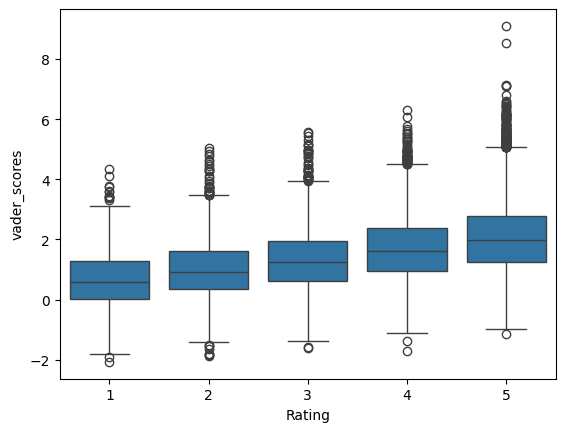

In [41]:
import seaborn as sns 

sns.boxplot(df, x="Rating", y="vader_scores")